### 9.6 用GPT-2生成文本

在这篇文章中，我们将了解如何使用基于Transformers架构的模型生成文本，并将使用这些知识来演示如何创建假新闻。目的是通过这个实例来演示这些模型的操作和使用。
首先，我们将介绍文本生成模型的理论介绍，然后介绍HuggingFace Transformers，这是我们将在文章的其余部分使用的Python库。然后，我们将重点介绍GPT-2模型，以及如何使用HuggingFace Transformers中可用的界面，既可以使用预先训练的模型生成文本，也可以使用自己的文本重新训练它们。

### 1.文本生成模型介绍

文本生成模型早在几十年前就开始开发，早在深度学习热潮之前。他的模型类型的目的是能够预测给定文本的单词或单词序列。下图是这些模型所做工作的简化表示，使用文本作为输入，模型能够在它所知道的单词词典上生成概率分布，并根据它进行选择。

### 2 Huggingface Transformers

Huggingface Transformers是一个Python库，它下载预先训练好的模型，用于以下任务：
- 自然语言理解，如情感分析
- 自然语言生成，如文本生成或文本翻译。  
库中有三个主要概念或类，我们将在整个帖子中使用：
- Tokenizer：它们存储每个模型的词汇表，并包括在作为模型输入的令牌嵌入索引列表中对字符串进行编码和解码的方法。
- 配置：它们包含构建模型所需的参数。使用预先训练的模型时不需要它们
= 模型：Pytorch或Keras模型与库预先训练的模型一起使用。

###  3.设置

首先，让我们导入所有要使用的包。具体而言，这些软件包的版本为：
Transformers>=4.4.2
datasets>=1.5.0
nlp
colorama==0.4.4
Pytorch>=1.9.1

In [1]:
import torch, os, re, pandas as pd, json
from sklearn.model_selection import train_test_split
from transformers import DataCollatorForLanguageModeling, DataCollatorWithPadding, GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, AutoConfig
from datasets import Dataset

In [2]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)  



### 9.6.1 下载GPT-2预训练模型

第一步是加载模型和模型将使用的tokenizer。我们都是通过分别存在于Huggingface Transformers GPT2LMHeadModel和GPT2Token中的GPT2类的接口来实现的。在这两种情况下，您都必须指定要使用的模型的版本，并且OpenAI发布的模型的4个维度可用：
- 'gpt2'
- 'gpt2-medium'
- 'gpt2-large'
- 'gpt2-xl'



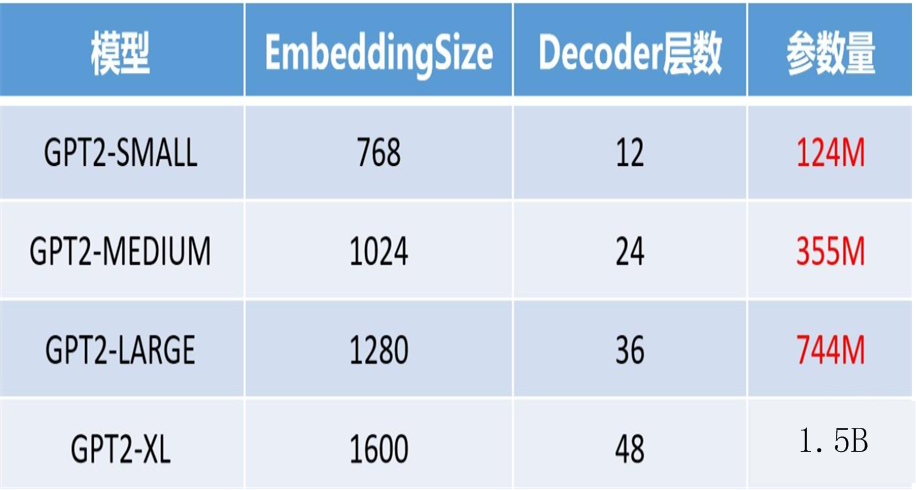

In [3]:
#get transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer
#GPT2LMHeadModel, GPT2Tokenizer

#get large GPT2 tokenizer and GPT2 model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
GPT2 = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)
# options: ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']
#一旦加载了模型，我们就可以探索参数及其体系结构：
GPT2.num_parameters

'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /gpt2/resolve/main/vocab.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001D77D630CD0>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/gpt2/resolve/main/vocab.json
'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /gpt2/resolve/main/config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001D77D630400>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/gpt2/resolve/main/config.json
'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /gpt2/resolve/main/generation_config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001D77DA4E6A0>, 'Connection to huggingface.co timed out. (connect 

<bound method ModuleUtilsMixin.num_parameters of GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)>

tokenizer有三个功能：    
它将输入文本分离为标记（Token），这些标记不一定与单词一致，并将这些标记编码和解码为模型的输入id，反之亦然。  
它允许向词汇表中添加新的标记  
它管理特殊的标记，如掩码、文本开头、文本结尾、特殊分隔符等。  
通过标记化器实例，我们可以探索词汇表（get_vocab）并查看其大小，还可以探索和使用标记化不同文本以了解其工作原理。

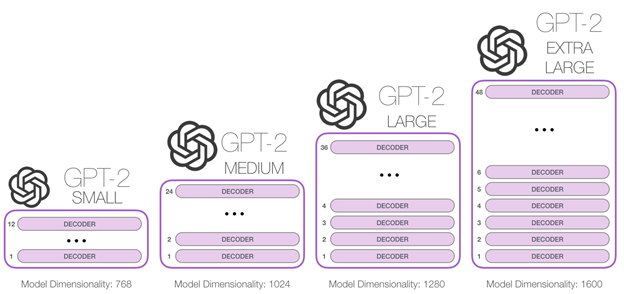

In [4]:
print('Words in vocabulary: ', tokenizer.vocab_size)

Words in vocabulary:  50257


In [5]:
vocabulary = tokenizer.get_vocab()
vocabulary['Hi']

17250

In [6]:
text = "Hi, I'm Victor and I work as a Data Scientist"
tokenizer.tokenize(text)


['Hi',
 ',',
 'ĠI',
 "'m",
 'ĠVictor',
 'Ġand',
 'ĠI',
 'Ġwork',
 'Ġas',
 'Ġa',
 'ĠData',
 'ĠScientist']

为了准备文本并将其转换为模型期望的格式，我们将使用encode函数，指定我们希望它以何种格式生成张量

In [7]:
text_ids = tokenizer.encode(text, return_tensors = 'pt')
text_ids

# tensorflow
#text_ids = base_tokenizer.encode(text, return_tensors = 'tf')


tensor([[17250,    11,   314,  1101, 12622,   290,   314,   670,   355,   257,
          6060, 33374]])

解码方法和参数
有了以上所有内容，我们就可以生成文本了。我们有一个标记化的文本和一个预训练的模型，我们可以调用generate函数，将标记化的文字作为输入传递。

In [8]:
text = "I work as a data scientist"
text_ids = tokenizer.encode(text, return_tensors = 'pt')

generated_text_samples = GPT2.generate(text_ids)
generated_text_samples


C:\Users\wumgapp\anaconda3\lib\site-packages\transformers\generation\utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tensor([[   40,   670,   355,   257,  1366, 11444,   379,   262,  2059,   286,
          3442,    11, 14727,    13,   198,   198,     1,    40,  1101,   407]])

由于输出再次是张量，使用tokenizer对逐个标记进行解码：

In [9]:
for i, beam in enumerate(generated_text_samples):
    print(f"{i}: {tokenizer.decode(beam, skip_special_tokens=True)}")
    print()


0: I work as a data scientist at the University of California, Berkeley.

"I'm not



所获得的文本的质量与选择下一个单词或给定短语的单词的方法有密切关系，给定短语的单词的方法可以基于传递给生成函数的参数来配置

### 9.6.2使用贪心搜索进行解码
这是最简单的方法，包括在所有可能的单词中选择概率最高的单词。它是在没有指定参数时使用的。
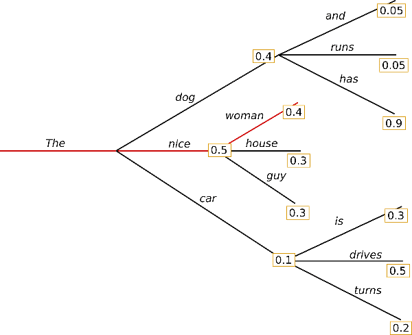

In [10]:
generated_text_samples = GPT2.generate(text_ids, max_length= 100,)

for i, beam in enumerate(generated_text_samples):
    print(f"{i}: {tokenizer.decode(beam, skip_special_tokens=True)}")
    print()


0: I work as a data scientist at the University of California, Berkeley.

"I'm not a scientist, but I'm a data scientist," he said. "I'm not a data scientist, but I'm a data scientist."

He said he's not sure how much of the data he's collecting is from the government, but he's confident that it's not too much.

"I'm not going to be able to do that," he said. "I'm



这是一种确定性生成，如果我们用相同的提示再次生成文本，则获得的文本是相同的。

In [11]:
generated_text_samples = GPT2.generate(text_ids, max_length= 100,)
for i, beam in enumerate(generated_text_samples):
  print(f"{i}: {tokenizer.decode(beam, skip_special_tokens=True)}")
  print()


0: I work as a data scientist at the University of California, Berkeley.

"I'm not a scientist, but I'm a data scientist," he said. "I'm not a data scientist, but I'm a data scientist."

He said he's not sure how much of the data he's collecting is from the government, but he's confident that it's not too much.

"I'm not going to be able to do that," he said. "I'm



这种方法的问题是：

- 它是确定性的
- 它可以进入一个循环并重复相同的单词
- 在低概率单词之后不考虑高概率单词

### 9.6.3使用束搜索进行解码
它将每个步骤中概率最高的B序列保存在内存中，最终选择概率最高的序列。参数B对应num_beams
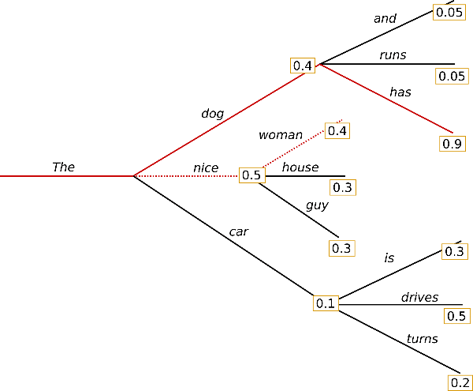

In [12]:
# 生成文本示例
generated_text_samples = GPT2.generate(
    text_ids,
    max_length= 50,  
    num_beams=5,
    num_return_sequences= 5,
    early_stopping=True 
)

for i, beam in enumerate(generated_text_samples):
  print(f"{i}: {tokenizer.decode(beam, skip_special_tokens=True)}")
  print()


0: I work as a data scientist at the University of California, Berkeley, and I've been working on this project for a long time. I've been working on this project for a long time. I've been working on this project for a long time

1: I work as a data scientist at the University of California, Berkeley, and I've been working on this for a long time. I've been working on this for a long time. I've been working on this for a long time.



2: I work as a data scientist at the University of California, Berkeley, and I've been working on this for a long time. I've been working on this for a long time. I've been working on this for a long time. I've

3: I work as a data scientist at the University of California, Berkeley, and I've been working on this for a long time. I've been working on this for a long time. I've been working on this for a long time. I'm

4: I work as a data scientist at the University of California, Berkeley, and I've been working on this for a long time. I've been working 

为了避免同一文本的重复，我们可以配置一个参数来防止重复所需长度的n-gram（no_rerept_gram_size）：

In [13]:
# 生成文本示例
generated_text_samples = GPT2.generate(
    text_ids,
    max_length= 50,  
    num_beams=5,
    no_repeat_ngram_size=2,
    num_return_sequences= 5,
    early_stopping=True 
)

for i, beam in enumerate(generated_text_samples):
  print(f"{i}: {tokenizer.decode(beam, skip_special_tokens=True)}")
  print()


0: I work as a data scientist at the University of California, Berkeley, and I've been working on this for a long time.

I have a lot of work to do, but I want to share it with you because I think it's

1: I work as a data scientist at the University of California, Berkeley, and I've been working on this for a long time.

I have a lot of work to do, but I want to share with you some of the things that I

2: I work as a data scientist at the University of California, Berkeley, and I've been working on this for a long time.

I have a lot of work to do, but I want to share it with you because it's important to

3: I work as a data scientist at the University of California, Berkeley, and I've been working on this for a long time.

I have a lot of work to do, but I want to share it with you because it's important.

4: I work as a data scientist at the University of California, Berkeley, and I've been working on this for a long time.

I have a lot of work to do, but I want to share it with y

### 问题：

- 它生成难以控制的重复序列
- 正如Ari-Holtzman等人（2019）所解释的那样，人类并不总是使用这种确定性语言。在他们的研究中，他们比较了人类和BeamSearch选择单词的概率，发现后者的概率要高得多，变化较小。
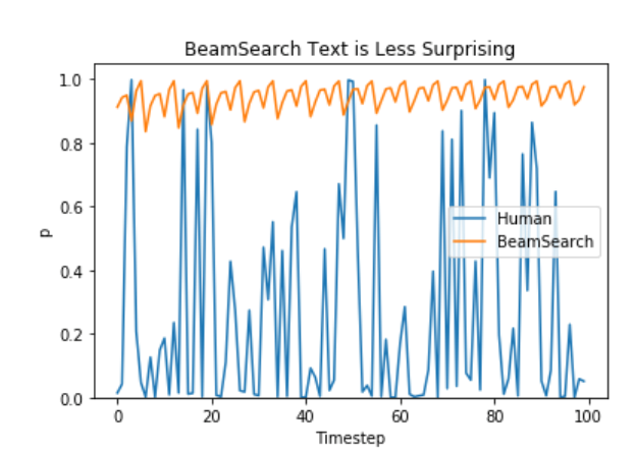

### 9.6.4用采样进行解码
下一个单词是基于由前一个单词条件概率分布随机选择的。
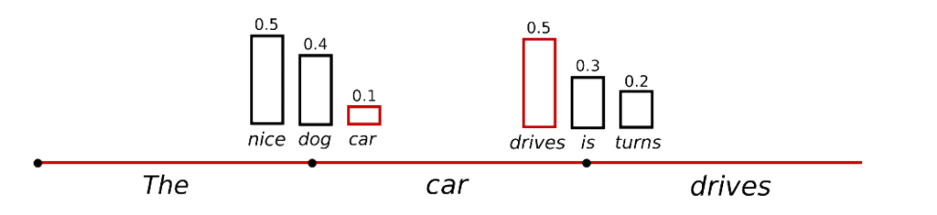

此外，可以调整分布的温度，以增加从最可能的单词中提取单词的概率
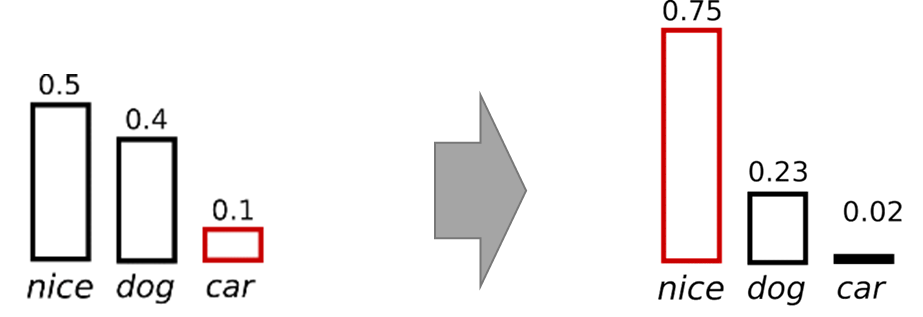

在采样中，有两种技术是不同的，即顶部K采样和顶部P采样。在实现它时，在这两种情况下，do_sample参数都将被传递为true。

In [15]:
# 生成文本示例
generated_text_samples = GPT2.generate(
    text_ids,
    max_length= 50,  
    do_sample=True,  
    top_k=0,
    num_return_sequences= 5
)

for i, beam in enumerate(generated_text_samples):
  print(f"{i}: {tokenizer.decode(beam, skip_special_tokens=True)}")
  print()


0: I work as a data scientist. PricewaterhouseCoopers is a developer at Hewlett Packard, and our work deals with systems and systems engineering."

She hopes that her idea will protect the organization's cybernetics research, including attack

1: I work as a data scientist at Sullivan Research Center and I have received many inquiries about the SSL/TLS problem. It seems that those who wish to back such an issue assert that those things should prevent web companies from otherwise resisting SSL and TLS.

2: I work as a data scientist at CERN and this is your chance to work under these exciting new algorithms. Let's get down to the cap on the conference. Let's set the procedure of the event! We will have a conference right here in

3: I work as a data scientist who found a massive page which included all the things you need to keep track of, like how your clean BMW builds, once you deploy it into your doors.

So this makes sense for this kind of language.

4: I work as a data scientist. I

现在我们可以试着调整温度参数。

In [16]:
# text generation example
generated_text_samples = GPT2.generate(
    text_ids,
    max_length= 50,  
    do_sample=True,  
    top_k=0,
    temperature=0.9,
    num_return_sequences= 5
)

for i, beam in enumerate(generated_text_samples):
  print(f"{i}: {tokenizer.decode(beam, skip_special_tokens=True)}")
  print()


0: I work as a data scientist. On a day-to-day basis, I would get no emails from the press or from their products, so I can't talk about them officially. But at the same time I'm a key member of the

1: I work as a data scientist. We're one of the markets where the price of data is stable. But as an in-house market, you get some data from many different sources; maybe from price of a broadcast; from performance of a database

2: I work as a data scientist and I let me take some of the photos of the mountain.

Miles Soudas: The photography is a bit like a professional mosaic. You can see a lot of the mountains.

Van den

3: I work as a data scientist and social media producer, and I think it is of great interest and help to help n fans, and considering social media helps create new CNN spots. You will see NAOC's attention, because the goal behind this is

4: I work as a data scientist working on statistics in electromagnetic physics at McGill University in Montreal.David Cameron's ever-

### 9.6.5用Top-K采样进行解码
第一个单词根据概率分布以 K 个单词中概率最高的前一个单词为条件，随机选择下一个单词。例如，如果我们想要生成从单词“The”开始的文本，并且给定词汇表上的以下概率分布，如果 K 为 6，则下一个单词将在单词nice、dog、car、woman、guy和man之间随机选择
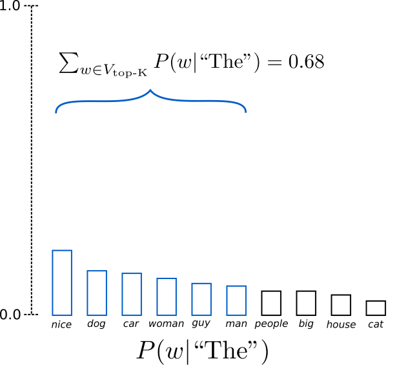

让我们尝试指定top_k参数：

In [17]:
# text generation example
generated_text_samples =GPT2.generate(
    text_ids,
    max_length= 50,  
    do_sample=True,  
    top_k=25,
    num_return_sequences= 5
)

for i, beam in enumerate(generated_text_samples):
  print(f"{i}: {tokenizer.decode(beam, skip_special_tokens=True)}")
  print()


0: I work as a data scientist. I'm passionate about data and data visualization, using Google's tools to create the best content possible.

1: I work as a data scientist to support this mission at NASA's Jet Propulsion Laboratory, a project of the Max Planck Institute for Evolutionary Anthropology in Bonn, Germany. This work is supported in part by a NASA grant to the Center for

2: I work as a data scientist. I work on a network of large data sets.

I am a senior scientist working for an enterprise, a technology company or a social security company in the UK.

I am an author of the new

3: I work as a data scientist and I'm really focused on building a lot of good content. There aren't a bunch of good content, there isn't a lot of good data, and the best content is the ones that we've developed for each

4: I work as a data scientist and data scientist for my employer, CNET.

My job is to improve the quality, transparency and confidentiality of our source code and provide feedback to 

### 9.6.6用Top-P采样进行解码
在 Top-P（也称为核采样）的情况下，根据概率分布随机选择下一个单词，该概率分布由前一个单词在添加概率大于或等于 p 的单词集合中决定。继续前面的示例，如果我们不设置可供选择的单词数量，而是决定在累积概率为 94% 的单词之间进行选择，则选项将会增加：
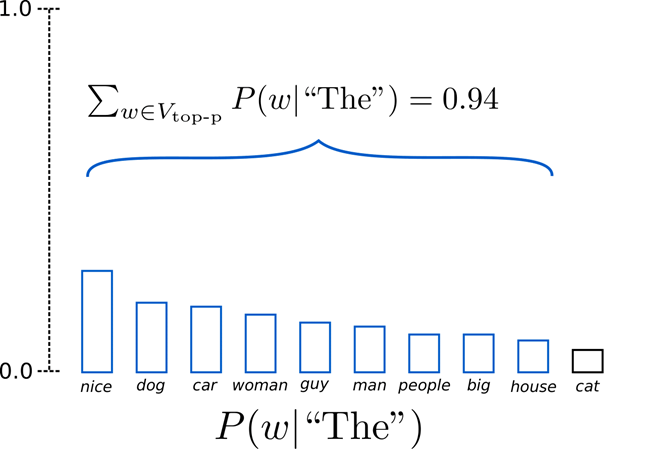

此方法由 top_p 参数指定，该参数接受 0 到 1 之间的值

In [18]:
# text generation example
generated_text_samples = GPT2.generate(
    text_ids,
    max_length= 50,  
    do_sample=True,  
    top_k=0,
    top_p=0.92,
    num_return_sequences= 5
)

for i, beam in enumerate(generated_text_samples):
  print(f"{i}: {tokenizer.decode(beam, skip_special_tokens=True)}")
  print()


0: I work as a data scientist, but I also write business textbooks for big companies. I want to know better, though I'm not particularly good at that. How can I overcome it? We'd love to hear from you... question if you could

1: I work as a data scientist because I want to be heard."

Sen. Patrick Leahy, D-Vt., a potential nominee for the Senate Intelligence Committee, acknowledged in a news release Wednesday that he doesn't think his notes refer to

2: I work as a data scientist on patterns in major observational studies. Recently, I noticed a new insight in the Hubble Deep Field observation that just blew my mind — that many more observations could have been made in the first half of the 20th century if

3: I work as a data scientist and a programmer, and you can stay out of this. I'd like to: 4 a.m. - 2 p.m. Friday, Oct. 30,

college entrance no. 4132 a)

4: I work as a data scientist, field editor of the Orlando Sentinel's digital content office and partner at Forbes.com. Read mor

### 9.6.7用综合方法进行解码
上述所有方法也可以组合起来。在下面的示例中，我们将调整分布的温度并同时定义 K 和 P。它将做的是保留最严格的一个，如果前 K 个单词的累积概率大于 P，则仅在累积概率为 P 的单词中选择所选单词，反之亦然。

In [19]:
# text generation example
generated_text_samples = GPT2.generate(
    text_ids,
    max_length= 50,  
    do_sample=True,  
    top_k=100,
    top_p=0.92,
    temperature=0.8,
    repetition_penalty= 1.5,
    num_return_sequences= 5
)

for i, beam in enumerate(generated_text_samples):
  print(f"{i}: {tokenizer.decode(beam, skip_special_tokens=True)}")
  print()


0: I work as a data scientist in the field of cybersecurity. I've also worked on my own research into how to improve encryption, and have been involved with various organizations trying solutions that could use encrypted communications," he said. "We are going through an

1: I work as a data scientist for my own blog. I don't get paid to do anything like this, but it's an incredibly rewarding experience so far in the business and hopefully they'll be happy with what we're doing next."
"With

2: I work as a data scientist at the University of California, Berkeley and I am part owner/operator of The Big Data Lab. Since 1998, he has worked on massive datasets like Internet companies' market research tools or IBM's software for predicting financial crises

3: I work as a data scientist and use open source tools to understand the technical problems involved in building distributed systems, such that they can be deployed from time-to—or even before. I hope you'll join me on my journey of lea

有了我们所看到的一切，我们将创建一个生成文本的函数，我们可以通过封装输入文本的标记化、使用 GPT-2 生成文本以及输出解码来以简单的方式使用该函数：

In [20]:
def generate_n_text_samples(model, tokenizer, input_text, device, n_samples = 5):
    text_ids = tokenizer.encode(input_text, return_tensors = 'pt')
    text_ids = text_ids.to(device)
    model = model.to(device)

    generated_text_samples = model.generate(
        text_ids, 
        max_length= 100,  
        num_return_sequences= n_samples,
        no_repeat_ngram_size= 2,
        repetition_penalty= 1.5,
        top_p= 0.92,
        temperature= .85,
        do_sample= True,
        top_k= 125,
        early_stopping= True
    )
    gen_text = []
    for t in generated_text_samples:
        text = tokenizer.decode(t, skip_special_tokens=True)
        gen_text.append(text)

        return gen_text


## <font color=blue>以下是参考文档</font>
### 4.微调：如何生成假新闻

GPT-2已经使用从互联网（维基百科、Reddit等）下载的通用文本进行了训练，因此，如果我们希望文本结构以某种方式或内容专注于一个主题，那么仅仅使用变形金刚中提供的预训练模型是不够的。为此，可以对模型进行微调，包括向架构添加一些层，并使用包含所需主题或文本结构的数据集重新训练模型。

微调允许您根据输入数据集控制生成的文本的结构和主题。此外，您不需要像GPT-2划痕训练那样大的数据量，这使它更经济实惠。
要进行微调，您必须遵循三个步骤：

- 获取数据
- 处理它以添加文本的开始和结束标记（或根据要生成的文本类型所需的标记）
- 使用此新数据训练基本模型

我们将生成新闻格式的文本（假新闻）：标题+文章。为此，需要两个模型：

- 标题生成模型，通过使用各种报纸的标题微调GPT-2小标题
- 文章生成模型，通过微调GPT-2小标题和文章，以便在给定标题的情况下生成文章的第一句。

我们将使用以下数据集作为2016年的头条新闻和新闻文章：https://www.kaggle.com/snapcrack/all-the-news?select=articles1.csv.大多数新闻都是关于特朗普、奥巴马和希拉里·克林顿的。

## 4.1 微调生成头条新闻
使用特殊标记加载标记生成器和模型
我们定义标题的开始和结束标记并添加它们：  
作为特殊标记传递给标记器，并且加载时预先训练的模型配置

In [21]:
# the eos and bos tokens are defined
bos = '<|endoftext|>'
eos = '<|EOS|>'
pad = '<|pad|>'

special_tokens_dict = {'eos_token': eos, 'bos_token': bos, 'pad_token': pad}

# the new token is added to the tokenizer
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)

# the model config to which we add the special tokens
config = AutoConfig.from_pretrained('gpt2', 
                                    bos_token_id=tokenizer.bos_token_id,
                                    eos_token_id=tokenizer.eos_token_id,
                                    pad_token_id=tokenizer.pad_token_id,
                                    output_hidden_states=False)

# the pre-trained model is loaded with the custom configuration
base_model = GPT2LMHeadModel.from_pretrained('gpt2', config=config)

#base_model = GPT2LMHeadModel.from_pretrained('gpt2', config=config,ignore_mismatched_sizes=True)

# the model embedding is resized
base_model.resize_token_embeddings(len(tokenizer))


'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /gpt2/resolve/main/config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001D77D658EB0>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/gpt2/resolve/main/config.json
'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /gpt2/resolve/main/generation_config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001D738668250>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/gpt2/resolve/main/generation_config.json


Embedding(50259, 768)

### 数据加载和处理
本例中的数据处理包括三个步骤：
- 清理数据集
- 将开始和结束标记添加到标题中
- 生成我们可以传递给模型进行训练的标记化数据集  

在训练模型之前清理和处理文本至关重要，因为噪声的存在会使重新训练的模型生成的文本质量比默认模型更差。因此我们要过滤标题：
- 空或为空
- 从出现该出版物的标题中删除该出版物的名称
- 丢弃少于 8 个字的标题
- 丢弃重复的标题

In [22]:
filepath= '../data/articles1.csv'
df = pd.read_csv(filepath, encoding = 'utf-8', usecols=['title', 'publication'])\
                    .rename(columns={'title': 'text'})

pd.set_option("display.max_colwidth", None)
df.head(5)


,text,publication
0,House Republicans Fret About Winning Their Health Care Suit - The New York Times,New York Times
1,Rift Between Officers and Residents as Killings Persist in South Bronx - The New York Times,New York Times
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial Bias, Dies at 106 - The New York Times",New York Times
3,"Among Deaths in 2016, a Heavy Toll in Pop Music - The New York Times",New York Times
4,Kim Jong-un Says North Korea Is Preparing to Test Long-Range Missile - The New York Times,New York Times


In [23]:
def remove_publication_headline(headline, publication):
    # publication col doesn't match exactly with newspaper in title col
    if str(publication) in str(headline):
        headline = headline.split(' - ')[0]
    return headline

def process_headlines(df, text_colname):
  
    # Remove empty and null rows
    titulo_vacio = (df['text'].str.len() == 0) | df['text'].isna()
    df = df[~titulo_vacio]

    # Remove publication name from title
    df['text'] = df.apply(lambda row: remove_publication_headline(row['text'], row['publication']), axis = 1)

    # Remove headlines with less than 8 words
    titlos_len_ge8 = (df['text'].str.split().apply(lambda x: len(x)) >= 8)
    df = df[titlos_len_ge8]

    # Drop duplicates
    text_df = df.drop_duplicates(subset = [text_colname])\
                [[text_colname]]

    return text_df
    
df = process_headlines(df, 'text')


一旦清理好数据集，就可以将开始和结束标记添加到标题中。然后将训练数据集和验证数据集分开。

In [24]:
df['text'] = bos + ' ' + df['text'] + ' ' + eos

df_train, df_val = train_test_split(df, train_size = 0.9, random_state = 77)
print(f'There are {len(df_train)} headlines for training and {len(df_val)} for validation')


There are 36380 headlines for training and 4043 for validation


现在，可以生成 HuggingFace Transformers 在内部使用的数据集，直接从 pandas 数据帧加载它们。本例，在生成数据集时丢弃所有不包含标题的列，因为它们不是必需的并且会占用内存空间。

In [25]:
# we load the datasets directly from a pandas df
train_dataset = Dataset.from_pandas(df_train[['text']])
val_dataset = Dataset.from_pandas(df_val[['text']])


最后，对数据集进行标记，以便可以将它们用作训练数据。使用 padding=True 在文本末尾添加填充标记，以便它们都具有相同的长度。

In [26]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding=True)

In [27]:
#tokenized_train_dataset = train_dataset.map(tokenize_function,batched=True,num_proc=5,remove_columns=['text'],)
tokenized_train_dataset = train_dataset.map(tokenize_function,batched=True,remove_columns=['text'],)

Map:   0%|          | 0/36380 [00:00<?, ? examples/s]

In [28]:
tokenized_val_dataset = val_dataset.map(tokenize_function,batched=True,remove_columns=['text'],)


Map:   0%|          | 0/4043 [00:00<?, ? examples/s]

In [29]:
# Example of the result of the tokenization process with padding
tokenizer.decode(tokenized_train_dataset['input_ids'][0])


'<|endoftext|> Donald Trump: Hillary Clinton ’Opened the Pandora’s Box of Radical Islam’ <|EOS|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>'

## 训练
在训练模型时，HuggingFace Transformers 有一个 API，可以将用户从过程中最复杂的细节中抽象出来。只需使用所需的参数值实例化 TrainingArguments 类，并将其作为参数传递给 Trainer 类。对于 GPT-2，还建议实例化 DataCollat​​orForLanguageModeling 类，该类负责生成训练子集（批次）。

在我们的例子中，除了 epoch 的数量和批次的大小之外，我们默认保留了几乎所有的训练参数。有关更多详细信息，界面中可用的所有参数均在 TrainingArguments 类的[文档] (https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments) 中提供并得到了很好的解释。我们通过将自定义分词器传递给数据整理器来实例化数据整理器，并停用“屏蔽语言建模”选项

In [30]:
model_headlines_path = './model_headlines_news'

training_args = TrainingArguments(
    output_dir=model_headlines_path,          # output directory
    num_train_epochs=6,              # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=200,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir=model_headlines_path,            # directory for storing logs
    prediction_loss_only=True,
    save_steps=10000 
)


In [31]:
data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False
    )


最后，我们实例化 Trainer 类，向其传递预训练的基础模型、训练参数、数据整理器以及训练和评估数据集。开始训练就像调用类的train函数一样简单，它将在屏幕上显示训练的进度。此外，如果我们在训练参数中定义了 save_step 参数，则该函数将在每次到达这些步骤时自动保存模型的检查点，并且可以从该检查点继续训练。

In [32]:
trainer = Trainer(
    model=base_model,                         # the instantiated  Transformers model to be trained
    args=training_args,                       # training arguments, defined above
    data_collator=data_collator,
    train_dataset=tokenized_train_dataset,         # training dataset
    eval_dataset=tokenized_val_dataset            # evaluation dataset
)
trainer.train()


C:\Users\wumgapp\anaconda3\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,9.143400
1000,4.042800
1500,3.920800
2000,3.839300
2500,3.700500
3000,3.548600
3500,3.552700
4000,3.543100
4500,3.525500
5000,3.320800


TrainOutput(global_step=13644, training_loss=3.507140205179761, metrics={'train_runtime': 3194.1818, 'train_samples_per_second': 68.337, 'train_steps_per_second': 4.272, 'total_flos': 5673987095040000.0, 'train_loss': 3.507140205179761, 'epoch': 6.0})

训练完成后，我们会保存它。它会保存在我们在TrainerArguments类中指定的文件夹中。

In [33]:
trainer.save_model()
tokenizer.save_pretrained(model_headlines_path)

('./model_headlines_news\\tokenizer_config.json',
 './model_headlines_news\\special_tokens_map.json',
 './model_headlines_news\\vocab.json',
 './model_headlines_news\\merges.txt',
 './model_headlines_news\\added_tokens.json')

此外，由于我们已经通过了一个评估集，我们可以在该数据集上评估模型的度量，并将其与列车的度量进行比较。

In [34]:
trainer.evaluate()

{'eval_loss': 3.6352007389068604,
 'eval_runtime': 15.5878,
 'eval_samples_per_second': 259.369,
 'eval_steps_per_second': 32.461,
 'epoch': 6.0}

## 标题生成
训练好模型后，我们就可以尝试生成头条新闻了！在本例中，我们使用起始标记 (bos_token) 作为模型的提示，我们可以看到模型生成的文本长度与标题相似，并且所有文本都与数据集中的标题主题相关。正如我们所料，特朗普和希拉里·克林顿是其中大多数的主角。也就是说，我们的模型已经成功学习了数据集的结构和主题。

In [35]:
# trained model loading
model_headlines_path = './model_headlines_news'


headlines_model = GPT2LMHeadModel.from_pretrained(model_headlines_path)
headlines_tokenizer = GPT2Tokenizer.from_pretrained(model_headlines_path)

device = "cuda:0"

input_text = headlines_tokenizer.bos_token

headlines = generate_n_text_samples(headlines_model, headlines_tokenizer, 
                                    input_text, device, n_samples = 10)
for h in headlines:
    print(h)
    print()


 Trump’s Supreme Court Pick: A New Kind of Justice for the Country



## 4.2 微调从标题生成文章
接下来，我们将重复从标题生成文章内容开头的过程。一般过程是相同的：加载预训练模型和标记器，添加我们需要的特殊标记，加载和处理数据，生成数据集并训练。主要区别在于我们如何处理数据，以便模型学习从标题开发内容。我们通过添加一个新的分隔标记并连接由此标记分隔的标题和新闻内容来实现此目的：

$ bos_token <title> sep_token <content> eos_token $
    
这样，在生成文本时，传递给模型的提示将包含标题和分隔标记，模型将学会生成有关标题内容的文本。

使用特殊标记加载标记生成器和模型

In [36]:
# special tokens are defined
bos = '<|endoftext|>'
eos = '<|EOS|>'
body = '<|body|>'
additional_special_tokens = [body]

special_tokens_dict = {'eos_token': eos, 'bos_token': bos, 'pad_token': '<pad>',
                       'sep_token': body} 
                      #  'additional_special_tokens':additional_special_tokens}

# the new token is added to the tokenizer
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)

# model configuration to which we add the special tokens
config = AutoConfig.from_pretrained('gpt2', 
                                    bos_token_id=tokenizer.bos_token_id,
                                    eos_token_id=tokenizer.eos_token_id,
                                    pad_token_id=tokenizer.pad_token_id,
                                    sep_token_id=tokenizer.sep_token_id,
                                    output_hidden_states=False)

# we load the pre-trained model with custom settings
base_model = GPT2LMHeadModel.from_pretrained('gpt2', config=config)

# model embeding resizing
base_model.resize_token_embeddings(len(tokenizer))


'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /gpt2/resolve/main/config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001D70A0DF700>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/gpt2/resolve/main/config.json
'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /gpt2/resolve/main/generation_config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001D70B502A00>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/gpt2/resolve/main/generation_config.json


Embedding(50261, 768)

## 数据加载和处理
过滤标题和文章：

- 空或为空
- 从出现该出版物的标题中删除该出版物的名称
- 丢弃少于 8 个字的标题
- 丢弃重复的标题
- 保留文章的前100字  
按说明处理添加标记的文本

In [71]:
df = []
for filepath in ['../data/articles1.csv', '../data/articles2.csv']:
    news_df = pd.read_csv(filepath, encoding = 'utf-8')
    df.append(news_df)
news_df = pd.concat(df, axis=0)

def remove_publication_headline(headline, publication):
    # publication col doesn't match exactly with newspaper in title col
    if str(publication) in str(headline):
        headline = headline.split(' - ')[0]
    return headline

  
def process_headlines_articles(df, title_col, content_col):
    # Remove rows with empty or null title or content
    titulo_vacio = (df[title_col].str.len() == 0) | df[title_col].isna()
    contenido_vacio = (news_df[content_col].str.len() == 0) | news_df[content_col].isna()
    df = df[~titulo_vacio & ~contenido_vacio]

    # Remove publication name from title
    df[title_col] = df.apply(lambda row: remove_publication_headline(row[title_col], row['publication']), axis = 1)

    # Remove headlines with less than 8 words
    titlos_len_ge8 = (df[title_col].str.split().apply(lambda x: len(x)) >= 8)
    df = df[titlos_len_ge8]

    # Keep the first 100 words from the content
    news_df[content_col] = news_df[content_col].str.split(' ').apply(lambda x: ' '.join(x[:100]))

    # Drop duplicates
    text_df = df.drop_duplicates(subset = [content_col])[[content_col]]

    return text_df


In [72]:
news_df.head(1)

Unnamed: 0     id  \
0           0  17283   

                                                                              title  \
0  House Republicans Fret About Winning Their Health Care Suit - The New York Times   

      publication      author        date    year  month  url  \
0  New York Times  Carl Hulse  2016-12-31  2016.0   12.0  NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [73]:
# Data cleansing
news_df = process_headlines_articles(news_df, title_col='title', content_col='content')

C:\Users\wumgapp\AppData\Local\Temp\ipykernel_8820\3286033868.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[title_col] = df.apply(lambda row: remove_publication_headline(row[title_col], row['publication']), axis = 1)


In [74]:
news_df.head(1)

content
0  WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government. To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the Obama health care law, angering conservative voters who have been demanding an end to the law for years. In another twist, Donald J. Trump’s administration, worried about preserving executive branch prerogatives, could choose to fight its Republican allies in the House on some central questions in the dispute. Eager to avoid an ugly political pileup, Republicans on Capitol Hill and the Trump transition team are gaming out how to handle the lawsuit, which, after the election, has been put in limbo until at least late February by the United States Court of Appeals for the District of Columbia Circuit. They are not yet ready to divulge their strategy. “Given that this pending litigation involves the Obama administration and Congress, it would be inappropriate to comment,” said Phillip J. Blando, a spokesman for the Trump transition effort. “Upon taking office, the Trump administration will evaluate this case and all related aspects of the Affordable Care Act. ” In a potentially   decision in 2015, Judge Rosemary M. Collyer ruled that House Republicans had the standing to sue the executive branch over a spending dispute and that the Obama administration had been distributing the health insurance subsidies, in violation of the Constitution, without approval from Congress. The Justice Department, confident that Judge Collyer’s decision would be reversed, quickly appealed, and the subsidies have remained in place during the appeal. In successfully seeking a temporary halt in the proceedings after Mr. Trump won, House Republicans last month told the court that they “and the  ’s transition team currently are discussing potential options for resolution of this matter, to take effect after the  ’s inauguration on Jan. 20, 2017. ” The suspension of the case, House lawyers said, will “provide the   and his future administration time to consider whether to continue prosecuting or to otherwise resolve this appeal. ” Republican leadership officials in the House acknowledge the possibility of “cascading effects” if the   payments, which have totaled an estimated $13 billion, are suddenly stopped. Insurers that receive the subsidies in exchange for paying    costs such as deductibles and   for eligible consumers could race to drop coverage since they would be losing money. Over all, the loss of the subsidies could destabilize the entire program and cause a lack of confidence that leads other insurers to seek a quick exit as well. Anticipating that the Trump administration might not be inclined to mount a vigorous fight against the House Republicans given the  ’s dim view of the health care law, a team of lawyers this month sought to intervene in the case on behalf of two participants in the health care program. In their request, the lawyers predicted that a deal between House Republicans and the new administration to dismiss or settle the case “will produce devastating consequences for the individuals who receive these reductions, as well as for the nation’s health insurance and health care systems generally. ” No matt

In [75]:
# We add the tokens
#prepare_text = lambda x: ' '.join([bos, x['title'], body, x['content'], eos])
prepare_text = lambda x: ' '.join([body, x['content'], eos])
news_df['text'] = news_df.apply(prepare_text, axis=1)

In [76]:
news_df.head(1)

content  \
0  WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government. To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the Obama health care law, angering conservative voters who have been demanding an end to the law for years. In another twist, Donald J. Trump’s administration, worried about preserving executive branch prerogatives, could choose to fight its Republican allies in the House on some central questions in the dispute. Eager to avoid an ugly political pileup, Republicans on Capitol Hill and the Trump transition team are gaming out how to handle the lawsuit, which, after the election, has been put in limbo until at least late February by the United States Court of Appeals for the District of Columbia Circuit. They are not yet ready to divulge their strategy. “Given that this pending litigation involves the Obama administration and Congress, it would be inappropriate to comment,” said Phillip J. Blando, a spokesman for the Trump transition effort. “Upon taking office, the Trump administration will evaluate this case and all related aspects of the Affordable Care Act. ” In a potentially   decision in 2015, Judge Rosemary M. Collyer ruled that House Republicans had the standing to sue the executive branch over a spending dispute and that the Obama administration had been distributing the health insurance subsidies, in violation of the Constitution, without approval from Congress. The Justice Department, confident that Judge Collyer’s decision would be reversed, quickly appealed, and the subsidies have remained in place during the appeal. In successfully seeking a temporary halt in the proceedings after Mr. Trump won, House Republicans last month told the court that they “and the  ’s transition team currently are discussing potential options for resolution of this matter, to take effect after the  ’s inauguration on Jan. 20, 2017. ” The suspension of the case, House lawyers said, will “provide the   and his future administration time to consider whether to continue prosecuting or to otherwise resolve this appeal. ” Republican leadership officials in the House acknowledge the possibility of “cascading effects” if the   payments, which have totaled an estimated $13 billion, are suddenly stopped. Insurers that receive the subsidies in exchange for paying    costs such as deductibles and   for eligible consumers could race to drop coverage since they would be losing money. Over all, the loss of the subsidies could destabilize the entire program and cause a lack of confidence that leads other insurers to seek a quick exit as well. Anticipating that the Trump administration might not be inclined to mount a vigorous fight against the House Republicans given the  ’s dim view of the health care law, a team of lawyers this month sought to intervene in the case on behalf of two participants in the health care program. In their request, the lawyers predicted that a deal between House Republicans and the new administration to dismiss or settle the case “will produce devastating consequences for the individuals who receive these reductions, as well as for the nation’s health insurance and health care systems generally. ” No m

In [77]:
# Split in train and test
df_train_news, df_val_news = train_test_split(news_df, train_size = 0.9, random_state = 77)

# we load the datasets from pandas df
train_dataset = Dataset.from_pandas(df_train_news[['text']])
val_dataset = Dataset.from_pandas(df_val_news[['text']])

# tokenization
tokenized_train_dataset = train_dataset.map(
    tokenize_function,
    batched=True,
    num_proc=1
)

tokenized_val_dataset = val_dataset.map(
    tokenize_function,
    batched=True,
    num_proc=1
)


Map:   0%|          | 0/69569 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1304 > 1024). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/7730 [00:00<?, ? examples/s]